## Overview:

Cab booking systems are a means of renting cabs where the process of booking is automated via a network of kiosk locations throughout a city. Using these systems, people are able book a cab from a one location and return it to a different place on an as-needed basis.

In [63]:
import pylab
import calendar
import numpy as np
import pandas as pd
import seaborn as sn
from scipy import stats
import missingno as msno
from datetime import datetime
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import warnings
pd.options.mode.chained_assignment = None
warnings.filterwarnings("ignore", category=DeprecationWarning)
%matplotlib inline
import seaborn as sns

##regression
from sklearn.linear_model import LinearRegression,Ridge,Lasso,RidgeCV
from sklearn.ensemble import RandomForestRegressor,BaggingRegressor,GradientBoostingRegressor,AdaBoostRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor

#evaluation metrics
from sklearn.metrics import mean_squared_log_error,mean_squared_error, r2_score,mean_absolute_error # for regression

#model selection
from sklearn.model_selection import train_test_split,cross_validate
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV

In [2]:
##Load the training data
train = pd.read_csv("./data/train.csv")
train_label = pd.read_csv("./data/train_label.csv", header = None)
test = pd.read_csv("./data/test.csv")

In [3]:
train.shape

(8708, 9)

In [4]:
train_label.shape

(8708, 1)

In [5]:
train['Total_booking'] = train_label[0]

In [6]:
##Check data types of data
train.dtypes

datetime          object
season            object
holiday            int64
workingday         int64
weather           object
temp             float64
atemp            float64
humidity           int64
windspeed        float64
Total_booking      int64
dtype: object

In [7]:
train.head()


,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,Total_booking
0,5/2/2012 19:00,Summer,0,1,Clear + Few clouds,22.14,25.760,77,16.9979,504
1,9/5/2012 4:00,Fall,0,1,Clear + Few clouds,28.70,33.335,79,19.0012,5
2,1/13/2011 9:00,Spring,0,1,Clear + Few clouds,5.74,6.060,50,22.0028,139
3,11/18/2011 16:00,Winter,0,1,Clear + Few clouds,13.94,16.665,29,8.9981,209
4,9/13/2011 13:00,Fall,0,1,Clear + Few clouds,30.34,33.335,51,19.0012,184


In [38]:
test.shape

(2178, 12)

## Feature Engineering
As we see from the above results, the columns "season","holiday","workingday" and "weather" should be of "categorical" data type.But the current data type is "int" for those columns. Let us transform the dataset.

Create new columns "date,"hour","weekDay","month" from "datetime" column.
Coerce the datatype of "season","holiday","workingday" and weather to category.
Drop the datetime column as we already extracted useful features from it.

### Creating New column from DateTime Column

In [9]:
train['date'] = train.datetime.apply(lambda x : x.split()[0])
train['hour'] = train.datetime.apply(lambda x : x.split()[1].split(":")[0])
train["weekday"] = train.date.apply(lambda dateString : calendar.day_name[datetime.strptime(dateString,"%m/%d/%Y").weekday()])
train["month"] = train.date.apply(lambda dateString : calendar.month_name[datetime.strptime(dateString,"%m/%d/%Y").month])

test['date'] = test.datetime.apply(lambda x : x.split()[0])
test['hour'] = test.datetime.apply(lambda x : x.split()[1].split(":")[0])
test["weekday"] = test.date.apply(lambda dateString : calendar.day_name[datetime.strptime(dateString,"%m/%d/%Y").weekday()])
test["month"] = test.date.apply(lambda dateString : calendar.month_name[datetime.strptime(dateString,"%m/%d/%Y").month])

In [10]:
train.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,Total_booking,date,hour,weekday,month
0,5/2/2012 19:00,Summer,0,1,Clear + Few clouds,22.14,25.760,77,16.9979,504,5/2/2012,19,Wednesday,May
1,9/5/2012 4:00,Fall,0,1,Clear + Few clouds,28.70,33.335,79,19.0012,5,9/5/2012,4,Wednesday,September
2,1/13/2011 9:00,Spring,0,1,Clear + Few clouds,5.74,6.060,50,22.0028,139,1/13/2011,9,Thursday,January
3,11/18/2011 16:00,Winter,0,1,Clear + Few clouds,13.94,16.665,29,8.9981,209,11/18/2011,16,Friday,November
4,9/13/2011 13:00,Fall,0,1,Clear + Few clouds,30.34,33.335,51,19.0012,184,9/13/2011,13,Tuesday,September


In [11]:
test.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,date,hour,weekday,month
0,5/10/2012 11:00,Summer,0,1,Clear + Few clouds,21.32,25.000,48,35.0008,5/10/2012,11,Thursday,May
1,6/9/2012 7:00,Summer,0,0,Clear + Few clouds,23.78,27.275,64,7.0015,6/9/2012,7,Saturday,June
2,3/6/2011 20:00,Spring,0,0,"Light Snow, Light Rain",11.48,12.120,100,27.9993,3/6/2011,20,Sunday,March
3,10/13/2011 11:00,Winter,0,1,Mist + Cloudy,25.42,28.790,83,0.0000,10/13/2011,11,Thursday,October
4,6/2/2012 12:00,Summer,0,0,Clear + Few clouds,25.42,31.060,43,23.9994,6/2/2012,12,Saturday,June


### Convert column types into categorical 

In [12]:
categoryVariableList = ["hour","weekday","month","season","weather","holiday","workingday"]
for var in categoryVariableList:
    train[var] = train[var].astype('category')
    test[var] = test[var].astype('category')

In [13]:
train.dtypes.value_counts()

float64     3
object      2
category    2
int64       2
category    1
category    1
category    1
category    1
category    1
dtype: int64

In [14]:
test.dtypes.value_counts()

float64     3
object      2
category    2
category    1
category    1
category    1
category    1
int64       1
category    1
dtype: int64

### Dropping Unncessary Columns

In [15]:
train  = train.drop(["datetime"],axis=1)
test = test.drop(["datetime"], axis=1)

In [16]:
train.columns

Index(['season', 'holiday', 'workingday', 'weather', 'temp', 'atemp',
       'humidity', 'windspeed', 'Total_booking', 'date', 'hour', 'weekday',
       'month'],
      dtype='object')

In [17]:
test.columns

Index(['season', 'holiday', 'workingday', 'weather', 'temp', 'atemp',
       'humidity', 'windspeed', 'date', 'hour', 'weekday', 'month'],
      dtype='object')

In [18]:
train.head()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,Total_booking,date,hour,weekday,month
0,Summer,0,1,Clear + Few clouds,22.14,25.760,77,16.9979,504,5/2/2012,19,Wednesday,May
1,Fall,0,1,Clear + Few clouds,28.70,33.335,79,19.0012,5,9/5/2012,4,Wednesday,September
2,Spring,0,1,Clear + Few clouds,5.74,6.060,50,22.0028,139,1/13/2011,9,Thursday,January
3,Winter,0,1,Clear + Few clouds,13.94,16.665,29,8.9981,209,11/18/2011,16,Friday,November
4,Fall,0,1,Clear + Few clouds,30.34,33.335,51,19.0012,184,9/13/2011,13,Tuesday,September


### Missing Value Analysis
Once we get hang of the data and columns, next step we geneally is to find out whether we have any missing values in our data. 

### Skewness in the data 

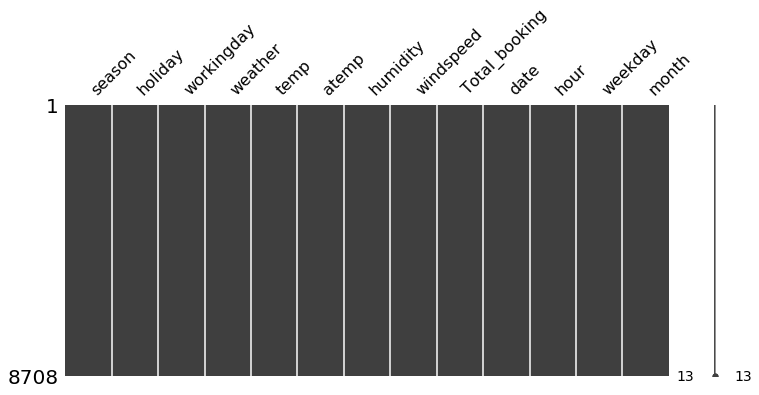

In [19]:
msno.matrix(train,figsize=(12,5))

### Outliers Analysis

Box plots across various features like season, hour of the day, workung_day etc to see if there are any outlier

[Text(0,0.5,'Total_booking'),
 Text(0.5,0,'Working Day'),
 Text(0.5,1,'Box Plot On total booking Across Working Day')]

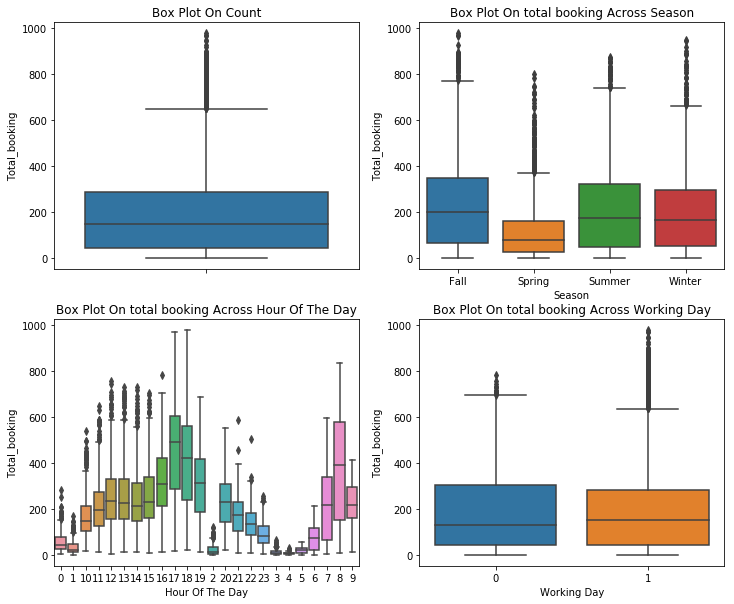

In [20]:
fig, axes = plt.subplots(nrows=2,ncols=2)
fig.set_size_inches(12, 10)
sn.boxplot(data=train,y="Total_booking",orient="v",ax=axes[0][0])
sn.boxplot(data=train,y="Total_booking",x="season",orient="v",ax=axes[0][1])
sn.boxplot(data=train,y="Total_booking",x="hour",orient="v",ax=axes[1][0])
sn.boxplot(data=train,y="Total_booking",x="workingday",orient="v",ax=axes[1][1])

axes[0][0].set(ylabel='Total_booking',title="Box Plot On Count")
axes[0][1].set(xlabel='Season', ylabel='Total_booking',title="Box Plot On total booking Across Season")
axes[1][0].set(xlabel='Hour Of The Day', ylabel='Total_booking',title="Box Plot On total booking Across Hour Of The Day")
axes[1][1].set(xlabel='Working Day', ylabel='Total_booking',title="Box Plot On total booking Across Working Day")

### Following inferences can also been made from the simple boxplots given above.

1) Spring season has got relatively lower count.The dip in median value in boxplot gives evidence for it.

2) The boxplot with "Hour Of The Day" is quiet interesting.The median value are relatively higher at 7AM - 8AM and 5PM - 6PM. It can be attributed to regular school and office users at that time.

3) Most of the outlier points are mainly contributed from "Working Day" than "Non Working Day". It is quiet visible from from figure 4.

In [21]:
## Removing outliers
trainWithoutOutliers = train[np.abs(train["Total_booking"]-train["Total_booking"].mean())<=(3*train["Total_booking"].std())]

In [22]:
print ("Shape Of The Before Ouliers: ",train.shape)
print ("Shape Of The After Ouliers: ",trainWithoutOutliers.shape)

Shape Of The Before Ouliers:  (8708, 13)
Shape Of The After Ouliers:  (8591, 13)


In [23]:
trainWithoutOutliers.head()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,Total_booking,date,hour,weekday,month
0,Summer,0,1,Clear + Few clouds,22.14,25.760,77,16.9979,504,5/2/2012,19,Wednesday,May
1,Fall,0,1,Clear + Few clouds,28.70,33.335,79,19.0012,5,9/5/2012,4,Wednesday,September
2,Spring,0,1,Clear + Few clouds,5.74,6.060,50,22.0028,139,1/13/2011,9,Thursday,January
3,Winter,0,1,Clear + Few clouds,13.94,16.665,29,8.9981,209,11/18/2011,16,Friday,November
4,Fall,0,1,Clear + Few clouds,30.34,33.335,51,19.0012,184,9/13/2011,13,Tuesday,September


### Correlation Analysis 
One common to understand how a dependent variable is influenced by features (numerical) is to find a correlation matrix between them. Lets plot a correlation plot between "total booking" and ["temp","atemp","humidity","windspeed"].

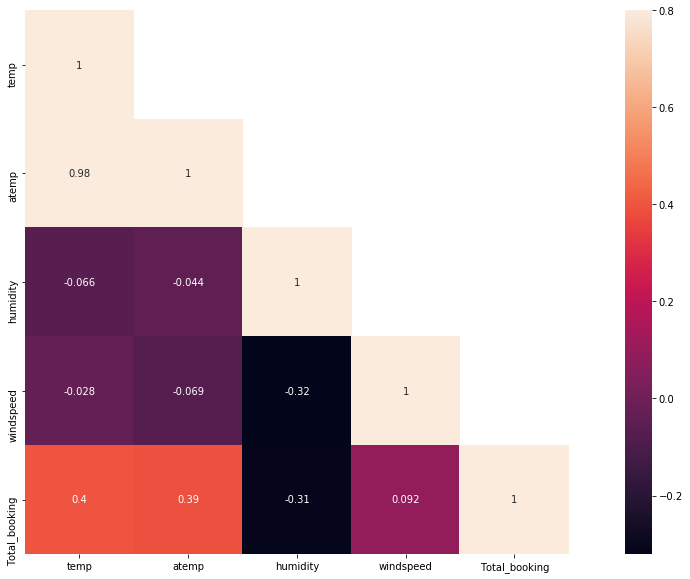

In [24]:
corrMatt = train[["temp","atemp","humidity","windspeed","Total_booking"]].corr()
mask = np.array(corrMatt)
mask[np.tril_indices_from(mask)] = False
fig,ax= plt.subplots()
fig.set_size_inches(20,10)
sn.heatmap(corrMatt, mask=mask,vmax=.8, square=True,annot=True)

### Correlation Plot analysis

1) temp and humidity features has got positive and negative correlation with Total_booking respectively.Although the correlation between them are not very prominent still the Total_booking variable has got little dependency on "temp" and "humidity".

2) windspeed is not gonna be really useful numerical feature and it is visible from it correlation value with "Total_booking"

3) "atemp" is variable is not taken into since "atemp" and "temp" has got strong correlation with each other. During model building any one of the variable has to be dropped since they will exhibit multicollinearity in the data.


### Visualizing Distribution Of Data

c:\users\karamjit.b.singh\appdata\local\continuum\anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
c:\users\karamjit.b.singh\appdata\local\continuum\anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


((array([-3.77290246, -3.54563229, -3.42075996, ...,  3.42075996,
          3.54563229,  3.77290246]),
  array([0.69314718, 0.69314718, 0.69314718, ..., 6.59850903, 6.60394382,
         6.60394382])),
 (1.344819111731776, 4.574704492098911, 0.957427556933226))

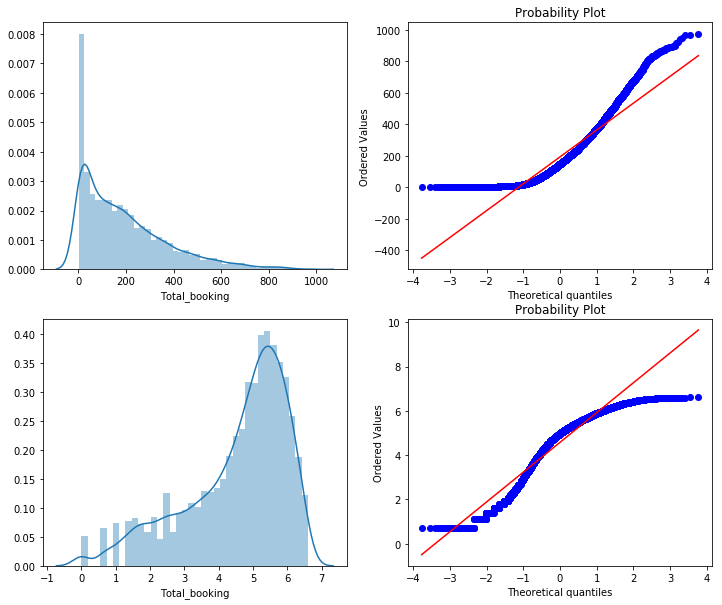

In [25]:
fig,axes = plt.subplots(ncols=2,nrows=2)
fig.set_size_inches(12, 10)
sn.distplot(train["Total_booking"],ax=axes[0][0])
stats.probplot(train["Total_booking"], dist='norm', fit=True, plot=axes[0][1])
sn.distplot(np.log(trainWithoutOutliers["Total_booking"]),ax=axes[1][0])
stats.probplot(np.log1p(trainWithoutOutliers["Total_booking"]), dist='norm', fit=True, plot=axes[1][1])

#### As it is visible from the above figures that "Total_booking" variable is skewed towards right. It is desirable to have Normal distribution as most of the machine learning techniques require dependent variable to be Normal. One possible solution is to take log transformation on "Total_booking" variable after removing outlier data points. After the transformation the data looks lot better but still not ideally following normal distribution.

### Visualizing Total_booking Vs (Month,Season,Hour,Weekday,Usertype) 

[Text(0,0.5,'Users Total_booking'),
 Text(0.5,0,'Hour Of The Day'),
 Text(0.5,1,'Average Users Total_booking By Hour Of The Day Across Weekdays'),
 None]

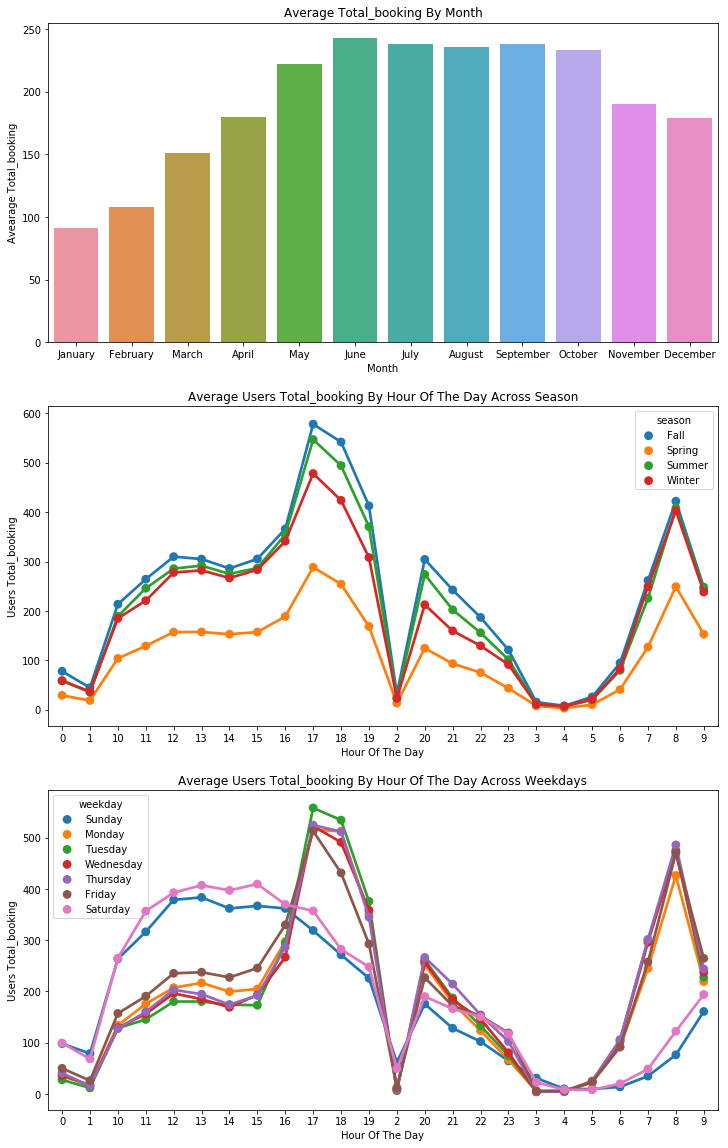

In [89]:
fig,(ax1,ax2,ax3)= plt.subplots(nrows=3)
fig.set_size_inches(12,20)
sortOrder = ["January","February","March","April","May","June","July","August","September","October","November","December"]
hueOrder = ["Sunday","Monday","Tuesday","Wednesday","Thursday","Friday","Saturday"]

monthAggregated = pd.DataFrame(train.groupby("month")["Total_booking"].mean()).reset_index()
monthSorted = monthAggregated.sort_values(by="Total_booking",ascending=False)
sn.barplot(data=monthSorted,x="month",y="Total_booking",ax=ax1,order=sortOrder)
ax1.set(xlabel='Month', ylabel='Avearage Total_booking',title="Average Total_booking By Month")

hourAggregated = pd.DataFrame(train.groupby(["hour","season"],sort=True)["Total_booking"].mean()).reset_index()
sn.pointplot(x=hourAggregated["hour"], y=hourAggregated["Total_booking"],hue=hourAggregated["season"], data=hourAggregated, join=True,ax=ax2)
ax2.set(xlabel='Hour Of The Day', ylabel='Users Total_booking',title="Average Users Total_booking By Hour Of The Day Across Season",label='big')

hourAggregated = pd.DataFrame(train.groupby(["hour","weekday"],sort=True)["Total_booking"].mean()).reset_index()
sn.pointplot(x=hourAggregated["hour"], y=hourAggregated["Total_booking"],hue=hourAggregated["weekday"],hue_order=hueOrder, data=hourAggregated, join=True,ax=ax3)
ax3.set(xlabel='Hour Of The Day', ylabel='Users Total_booking',title="Average Users Total_booking By Hour Of The Day Across Weekdays",label='big')


### Analysis of above plots:

1) It is quiet obvious that people tend to book a cab during summer season since it is really conducive to book a cab at that season.Therefore June, July and August has got relatively higher demand for cab booking.

2) On weekdays more people tend to book cab around 7AM-8AM and 5PM-6PM. As we mentioned earlier this can be attributed to regular school and office commuters.

3) Above pattern is not observed on "Saturday" and "Sunday".More people tend to book a cab between 10AM and 4PM.

4) The peak user total_booking around 7AM-8AM and 5PM-6PM is purely contributed by registered user.


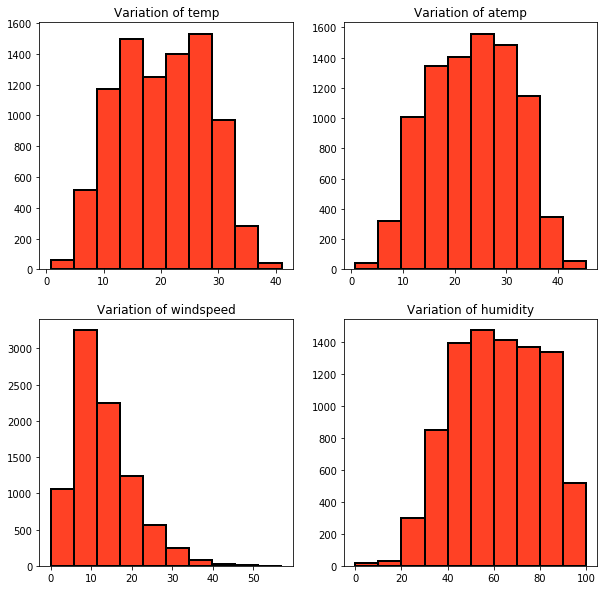

In [90]:
# can also be visulaized using histograms for all the continuous variables.
train.temp.unique()
fig,axes=plt.subplots(2,2)
axes[0,0].hist(x="temp",data=train,edgecolor="black",linewidth=2,color='#ff4125')
axes[0,0].set_title("Variation of temp")
axes[0,1].hist(x="atemp",data=train,edgecolor="black",linewidth=2,color='#ff4125')
axes[0,1].set_title("Variation of atemp")
axes[1,0].hist(x="windspeed",data=train,edgecolor="black",linewidth=2,color='#ff4125')
axes[1,0].set_title("Variation of windspeed")
axes[1,1].hist(x="humidity",data=train,edgecolor="black",linewidth=2,color='#ff4125')
axes[1,1].set_title("Variation of humidity")
fig.set_size_inches(10,10)

### Converting categorical variables into one hot vector 

In [32]:
fullData = train.append(test, sort=False)
fullData.reset_index(inplace=True)
fullData.drop('index',inplace=True,axis=1)
fullData.shape
fullData.head()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,Total_booking,date,hour,weekday,month
0,Summer,0,1,Clear + Few clouds,22.14,25.760,77,16.9979,504.0,5/2/2012,19,Wednesday,May
1,Fall,0,1,Clear + Few clouds,28.70,33.335,79,19.0012,5.0,9/5/2012,4,Wednesday,September
2,Spring,0,1,Clear + Few clouds,5.74,6.060,50,22.0028,139.0,1/13/2011,9,Thursday,January
3,Winter,0,1,Clear + Few clouds,13.94,16.665,29,8.9981,209.0,11/18/2011,16,Friday,November
4,Fall,0,1,Clear + Few clouds,30.34,33.335,51,19.0012,184.0,9/13/2011,13,Tuesday,September


In [40]:
categoryVariableList = ["hour","weekday","month","season","weather","holiday","workingday"]
for var in categoryVariableList:
    fullData[var] = fullData[var].astype('category')
fullData.dtypes

season           category
holiday          category
workingday       category
weather          category
temp              float64
atemp             float64
humidity            int64
windspeed         float64
Total_booking     float64
date               object
hour             category
weekday          category
month            category
dtype: object

In [37]:
fullData.shape

(10886, 13)

In [41]:
season=pd.get_dummies(fullData['season'])
fullData=pd.concat([fullData,season],axis=1)

weather=pd.get_dummies(fullData['weather'])
fullData=pd.concat([fullData,weather],axis=1)

weekday=pd.get_dummies(fullData['weekday'])
fullData=pd.concat([fullData,weekday],axis=1)

month=pd.get_dummies(fullData['month'])
fullData=pd.concat([fullData,month],axis=1)


In [42]:

fullData.head()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,Total_booking,date,...,December,February,January,July,June,March,May,November,October,September
0,Summer,0,1,Clear + Few clouds,22.14,25.760,77,16.9979,504.0,5/2/2012,...,0,0,0,0,0,0,1,0,0,0
1,Fall,0,1,Clear + Few clouds,28.70,33.335,79,19.0012,5.0,9/5/2012,...,0,0,0,0,0,0,0,0,0,1
2,Spring,0,1,Clear + Few clouds,5.74,6.060,50,22.0028,139.0,1/13/2011,...,0,0,1,0,0,0,0,0,0,0
3,Winter,0,1,Clear + Few clouds,13.94,16.665,29,8.9981,209.0,11/18/2011,...,0,0,0,0,0,0,0,1,0,0
4,Fall,0,1,Clear + Few clouds,30.34,33.335,51,19.0012,184.0,9/13/2011,...,0,0,0,0,0,0,0,0,0,1


In [43]:
fullData.drop(['season','weather', 'date', 'weekday','month' ],inplace=True,axis=1)
fullData.head()

,holiday,workingday,temp,atemp,humidity,windspeed,Total_booking,hour,Fall,Spring,...,December,February,January,July,June,March,May,November,October,September
0,0,1,22.14,25.760,77,16.9979,504.0,19,0,0,...,0,0,0,0,0,0,1,0,0,0
1,0,1,28.70,33.335,79,19.0012,5.0,4,1,0,...,0,0,0,0,0,0,0,0,0,1
2,0,1,5.74,6.060,50,22.0028,139.0,9,0,1,...,0,0,1,0,0,0,0,0,0,0
3,0,1,13.94,16.665,29,8.9981,209.0,16,0,0,...,0,0,0,0,0,0,0,1,0,0
4,0,1,30.34,33.335,51,19.0012,184.0,13,1,0,...,0,0,0,0,0,0,0,0,0,1


In [44]:
fullData.shape

(10886, 35)

In [45]:
df_train = fullData[:train.shape[0]]
df_test = fullData[train.shape[0]:]

In [46]:
df_train.shape, df_test.shape

((8708, 35), (2178, 35))

In [49]:
df_test.drop('Total_booking', inplace=True, axis=1)

In [51]:
df_test.shape

(2178, 34)

In [52]:
x_train,x_dev,y_train,y_dev =train_test_split(df_train.drop('Total_booking',axis=1),df_train['Total_booking'],test_size=0.20,random_state=42)

In [53]:
x_train.shape

(6966, 34)

### Let us fit various models and see which model works best 

Note: You can always try more models in the sam way

In [70]:
models=[RandomForestRegressor(),AdaBoostRegressor(),BaggingRegressor(),SVR(),KNeighborsRegressor()]
model_names=['RandomForestRegressor','AdaBoostRegressor','BaggingRegressor','SVR','KNeighborsRegressor']
rmsle=[]
d={}
for model in range (len(models)):
    clf=models[model]
    clf.fit(x_train,y_train)
    test_pred=clf.predict(x_dev)
    rmsle.append(np.sqrt(mean_squared_log_error(test_pred,y_dev)))
d={'Modelling Algo':model_names,'RMSLE':rmsle}

c:\users\karamjit.b.singh\appdata\local\continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
c:\users\karamjit.b.singh\appdata\local\continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


In [71]:
d

{'Modelling Algo': ['RandomForestRegressor',
  'AdaBoostRegressor',
  'BaggingRegressor',
  'SVR',
  'KNeighborsRegressor'],
 'RMSLE': [0.42948507384167733,
  0.9707327265327561,
  0.42300986822801784,
  1.378547651812974,
  0.8806417622444831]}

In [72]:
rmsle_frame=pd.DataFrame(d)

rmsle_frame


,Modelling Algo,RMSLE
0,RandomForestRegressor,0.429485
1,AdaBoostRegressor,0.970733
2,BaggingRegressor,0.423010
3,SVR,1.378548
4,KNeighborsRegressor,0.880642


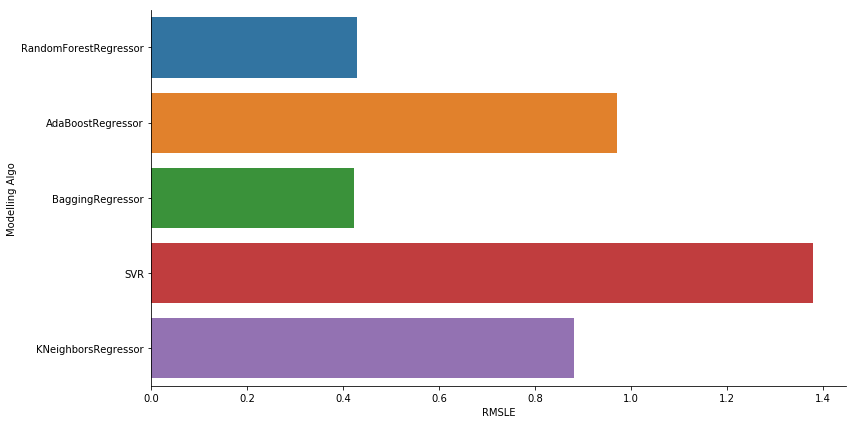

In [73]:
sns.factorplot(y='Modelling Algo',x='RMSLE',data=rmsle_frame,kind='bar',size=6,aspect=2)

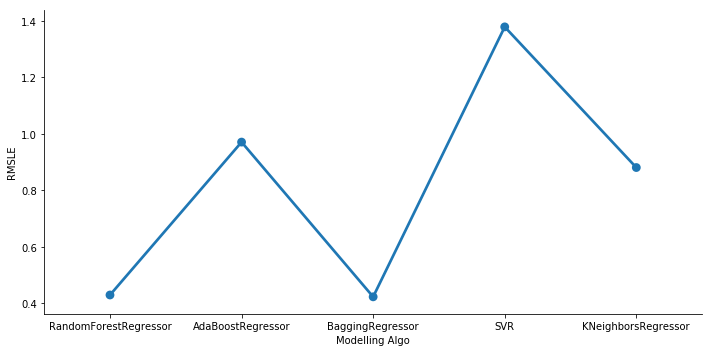

In [74]:
sns.factorplot(x='Modelling Algo',y='RMSLE',data=rmsle_frame,kind='point',size=5,aspect=2)

### Let us tune Random forest a bit... 

In [59]:
#for random forest regresion.
no_of_test=[300, 500, 700]
params_dict={'n_estimators':no_of_test,'n_jobs':[-1],'max_features':["auto",'sqrt','log2']}
clf_rf=GridSearchCV(estimator=RandomForestRegressor(),param_grid=params_dict,scoring='neg_mean_squared_log_error')
clf_rf.fit(x_train,y_train)
pred=clf_rf.predict(x_dev)
print((np.sqrt(mean_squared_log_error(pred,y_dev))))

c:\users\karamjit.b.singh\appdata\local\continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


0.4105764100292374


In [60]:
clf_rf.best_params_

{'max_features': 'auto', 'n_estimators': 700, 'n_jobs': -1}

#### Similarly you can tune various algorithms

### Testing Pipeline 

In [76]:
pred=clf_rf.predict(df_test)

In [78]:
pred.shape

(2178,)

In [79]:
test_labels = pd.read_csv("./data/test_label.csv", header = None)

In [80]:
test_labels.shape

(2178, 1)

In [85]:
test_array = test_labels.values.reshape(test_labels.shape[0])

In [87]:
test_array.shape

(2178,)

In [88]:
print((np.sqrt(mean_squared_log_error(pred,test_array))))

0.4253962537632082
